<a href="https://www.kaggle.com/code/nirmitgavate1/backpack-price-prediction?scriptVersionId=230921454" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


## Backpack Price Prediction Report

**Report-1**
*Train Test Split(20% test data)*
* filling numerical null vals with mean and topmost val for nulls in object cols
* le cols:`['Brand','Color','Material','Style','Size']`
* ohe cols:`['Laptop Compartment','Waterproof']`
* LinearRegressor default model
* without concat score:`39.16330`
* with concat score:`39.16099`

**Report-2**
*Train Test Split(20% test data)*
* filling numerical null vals with median and topmost val for nulls in object cols
* LinearRegressor default model
* encoding all obj cols in ohe type
* score:`39.14988`
* XGBRegressor default model score:`39.14936`

**Report-3**
*KFold(5 splits)*
* filling numerical null vals with mean and topmost val for nulls in object cols
* encoding all obj cols in ohe type
* XGBRegressor default model
* score:`39.14512`

**Report-4**
*KFold(5 splits)*
* filling numerical null vals with mean and `missing` val for nulls in object cols
* encoding all obj cols in ohe type
* XGBRegressor default model
* score:`39.12374`

**Report-4**
*KFold(5 splits)*
* filling numerical null vals with mean and `missing` val for nulls in object cols
* encoding all obj cols in ohe type
* basic FE for numeric cols
* XGBRegressor default model
* score:`39.12372`

**Report-4**
*KFold(5 splits)*
* filling numerical null vals with mean and `missing` val for nulls in object cols
* encoding all obj cols in ohe type
* basic FE for numeric cols
* XGBRegressor default model
* score:`39.12372`

**Report-4**
*KFold(10 splits)*
* filling numerical null vals with mean and `missing` val for nulls in object cols
* encoding all obj cols in ohe type
* basic FE for numeric cols
* LGBMRegressor default model
* score:`39.11194`

**Report-5**
*KFold(10 splits)*
* filling numerical null vals with mean and `missing` val for nulls in object cols
* encoding all obj cols in ohe type
* FE for cols (basic)
* XGBRegresor default model
* score:`39.11194`

**Report-6**
*KFold(10 splits)*
* filling numerical null vals with mean and `missing` val for nulls in object cols
* target encoding all obj cols  
* FE for cols (basic)
* LGBMRegressor default model
* score:`39.10660`

**Report-7**
*TT split*
* filling numerical null vals with mean and `missing` val for nulls in object cols
* target encoding all obj cols  
* No FE
* Basic NN model
* score:`39.10660`

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from cuml.preprocessing import TargetEncoder
from xgboost import XGBRegressor

import tensorflow as tf
import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2


In [3]:
train_df=pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
test_df=pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
train_extra=pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")

In [4]:
train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [5]:
test_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


In [8]:
train_df=pd.concat([train_df,train_extra])

In [9]:
train_null_percentage=(train_df.isnull().sum()/len(train_df))*100
train_null_percentage=train_null_percentage[train_null_percentage>0]
train_null_percentage

Brand                   3.173458
Material                2.777996
Size                    2.197747
Laptop Compartment      2.466829
Waterproof              2.361454
Style                   2.608205
Color                   3.345177
Weight Capacity (kg)    0.045264
dtype: float64

<Axes: >

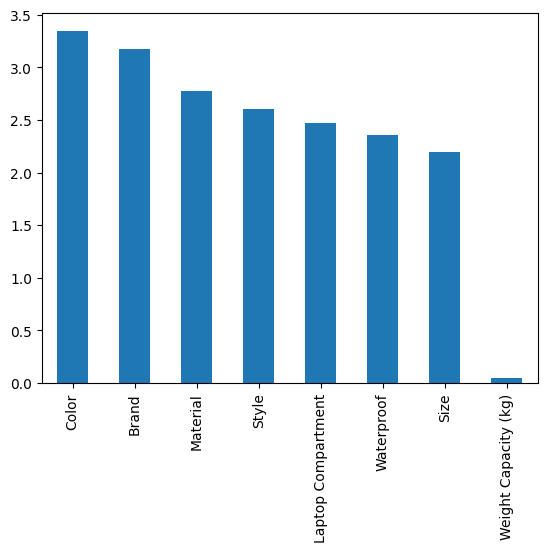

In [10]:
train_null_percentage.sort_values(ascending=False).plot(kind='bar')

In [11]:
test_null_percentage=(test_df.isnull().sum()/len(test_df))*100
test_null_percentage=test_null_percentage[test_null_percentage>0]
test_null_percentage

Brand                   3.1135
Material                2.8065
Size                    2.1905
Laptop Compartment      2.4810
Waterproof              2.4055
Style                   2.5765
Color                   3.3925
Weight Capacity (kg)    0.0385
dtype: float64

<Axes: >

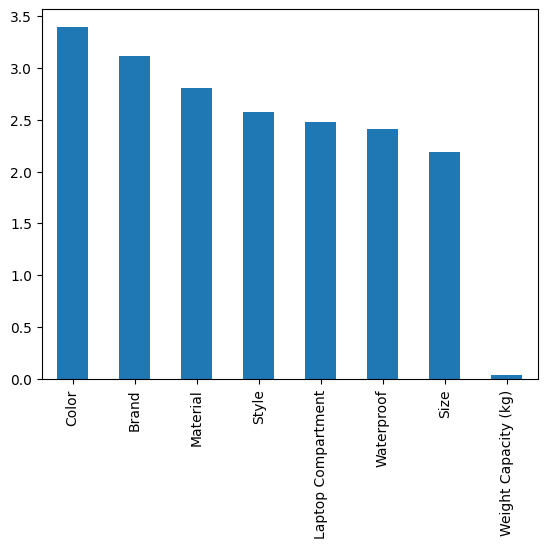

In [12]:
test_null_percentage.sort_values(ascending=False).plot(kind='bar')

In [13]:
numeric_cols=set(train_df.select_dtypes(exclude='object').columns)
object_cols=set(train_df.select_dtypes(include='object').columns)

## Filling null vals

In [14]:
for col in object_cols:
    train_df[col]=train_df[col].fillna('missing')
    test_df[col]=test_df[col].fillna('missing')

In [15]:
si=SimpleImputer(missing_values=np.nan,strategy='mean')
train_weights=si.fit_transform(train_df['Weight Capacity (kg)'].values.reshape(-1,1))
train_df['Weight Capacity (kg)']=train_weights.reshape(-1,)
test_weights=si.transform(test_df['Weight Capacity (kg)'].values.reshape(-1,1))
test_df['Weight Capacity (kg)']=test_weights.reshape(-1,)

# encoding obj cols

In [16]:
TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
for col in object_cols:
    TE.fit(train_df[col],train_df['Price'])
    train_df[col]=TE.transform(train_df[col])
    test_df[col]=TE.transform(test_df[col])

In [17]:
X=train_df.drop('Price',axis=1)
y=train_df['Price']

In [18]:
# kf=KFold(10)
# def get_preds(model_name):
#     cv_score=[]
#     all_idx=[]
#     for i,(train_idx,test_idx) in enumerate(kf.split(X,y)):
#         X_train,y_train=X.iloc[train_idx],y.iloc[train_idx]
#         X_test,y_test=X.iloc[test_idx],y.iloc[test_idx]
#         scaler=StandardScaler()
#         scaled_X_train=scaler.fit_transform(X_train)
#         scaled_X_test=scaler.transform(X_test)
#         model=model_name()
#         model.fit(scaled_X_train,y_train)
#         predictions=model.predict(scaled_X_test)
#         score=np.sqrt(mean_squared_error(y_test,predictions))
#         cv_score.append(score)
#         all_idx.append((train_idx,test_idx))
#     return cv_score,all_idx

In [19]:
# cv_score,all_idx=get_preds(LGBMRegressor)

In [20]:
# def test_predictions(model_name):
#     best_idx=np.argmin(cv_score)
#     best_train_idx,best_test_idx=all_idx[best_idx]
    
#     X_train,y_train=X.iloc[best_train_idx],y.iloc[best_train_idx]
#     X_test,y_test=X.iloc[best_test_idx],y.iloc[best_test_idx]
    
#     scaler=StandardScaler()
#     scaled_X_train=scaler.fit_transform(X_train)
#     scaled_X_test=scaler.transform(X_test)
    
#     model=model_name()
#     model.fit(scaled_X_train,y_train)
    
#     scaled_test_df=scaler.transform(test_df)
#     test_preds=model.predict(scaled_test_df)
#     sub=pd.DataFrame({"id":test_df["id"],
#                       "Price":test_preds
#                      })
#     feature_importance = model.feature_importances_
#     feat_df=pd.DataFrame(data=feature_importance,index=X_train.columns,columns=['feat_imp'])
#     return sub,feat_df
    

In [21]:
# sub,feat_df=test_predictions(LGBMRegressor)

In [22]:
# plt.figure(figsize=(13,6))
# feat_df.sort_values(ascending=False,by='feat_imp').plot(kind='barh',color='red')
# plt.title('Feature Importance')
# plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(X_train)
scaled_X_test=scaler.transform(X_test)
scaled_test_df=scaler.transform(test_df)